In [1]:
from data_retriever import DataRetriever
from pre_processing import PreProcessing
from scalers.min_max import MinMax
from regressors.lstm_regressor import LSTMRegressor
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from decomposers.wavelet_transform import WaveletDecomposition
from chm.chm import CascadeHierarquicalModel

In [2]:
from typing                 import List
from chm.level              import CHMLevel
from chm.stages             import CHMStage
from decomposers.decomposer import BaseDecomposer
from regressors.regressor   import BaseRegressor
from copy import copy
from pandas.core.frame import DataFrame
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt
import os
from math import floor

class CascadeHierarquicalModel():
    """
    Cascade Hierarquical Model used to extract context from timeseries and predict non stationary timeseries

    parameters : BaseRegressor    (Instanciated base regressor used to extract context)
                 BaseRegressor    (Instanciated base regressor used to join context created from the stages)
                 SeriesDecomposer (decomposition used to extract frequency from time series)
                 int              (number of levels in the hierarquical model)
                 int              (number of stages in the hierarquical model)
                 bool             (use frequency extracted from time series as a feature)
    
    """
    
    def __init__(self,  ds:DataFrame                      ,
                        # x_cols:List[str]                  ,
                        y_cols:str                        ,
                        context_regressor:BaseRegressor   , 
                        stage_regressor:BaseRegressor     ,
                        decomposer:BaseDecomposer         ,
                        dec_cols:List[str]                ,
                        num_stages:int=1                  ,
                        use_frequency:bool=False          ,
                        verbose=True
                ):
        self._ds                                   = ds
        # self._x_cols                             = x_cols
        self._y_cols                               = y_cols
        self._context_regressor                    = context_regressor
        self._stage_regressor                      = stage_regressor
        self._dec                                  = decomposer()
        self._dec_cols                             = dec_cols
        self._num_stages                           = num_stages
        self._use_frequency                        = use_frequency
        self._list_stages_bottom_up:List[CHMStage] = list()
        self._list_levels_frequency:List[CHMLevel] = list()
        self._verbose                              = verbose
        self._n_inputs                             = 7
        # Decomposing series
        self._dec.decompose_series(
                                    ds         = self._ds,
                                    apply_cols = self._dec_cols
                                )
        
        # Obtaining the biggest decomposition
        self._max_wave = len(self._dec.dict_waves[y_cols])
        
    def train_context_extraction(self) -> None:
        self._set_bottom_up_block()
        self._train_bottom_up_block()
        self._set_frequency_predictor_block()
        self._train_frequency_block()
        self._set_top_down_block()
        self._train_top_down_block()
    

    def _train_top_down_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Training top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage._regressor.fit_generator()
            if self._verbose:
                print('Training topdown regressor of Stage > ', stage_number)

    def _set_top_down_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting top-down regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            stage_ds = pd.DataFrame()
            if self._verbose:
                print('Creating topdown regressor of Stage > ', stage_number)

            for level, level_number in zip(stage._level_list, range(len(stage._level_list))):
                stage_ds['context_level_' + str(level_number)] = level.gerenerated_context.ravel()
            
            for level, level_number in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
                stage_ds['frequency_level_' + str(level_number)] = level.gerenerated_context.ravel()

            top_down_ds = pd.DataFrame()
            for level in range(len(stage._level_list)):
                top_down_ds['input_level_' + str(level)] = stage_ds['context_level_' + str(level)]
                for frequency_level, frequency_reversed in zip(range(len(stage._level_list)), reversed(range(len(stage._level_list)))):
                    if frequency_level < level :
                        top_down_ds['input_level_' + str(level)] = top_down_ds['input_level_' + str(level)] + stage_ds['frequency_level_' + str(frequency_reversed)]
            
            top_down_ds[self._y_cols] = self._ds[self._y_cols].to_list()[self._n_inputs:]
            curr_feat_cols = top_down_ds.columns.difference([self._y_cols])
    
            stage._regressor = self._context_regressor(
                                                        ds=top_down_ds, 
                                                        x_cols=curr_feat_cols, 
                                                        y_cols=self._y_cols, 
                                                        n_inputs=self._n_inputs, 
                                                        n_features=len(curr_feat_cols), 
                                                        epochs=50
                                                    )
        
    def _train_frequency_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Training frequencies regressors ...')
        for level, level_number in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
            if self._verbose:
                    print('Training Level > ', level_number, ', of Frequency Block')            
            level.train()

            if(self._verbose):
                print('Creating Context > ', 'Level > ', level_number)
            # Creating context for level
            level.create_context(level._regressor.ds[level._regressor.x_cols])

    def _train_bottom_up_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Training bottom up regressors ...')
        for stage, stage_number in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
             for level, level_number in zip(stage._level_list, range(len(stage._level_list))):
                if(self._verbose):
                    print('Training Regressors > ', 'Level > ', level_number, ' of Stage > ', stage_number)
                # Training Level
                level.train()

                if(self._verbose):
                    print('Creating Context > ', 'Level > ', level_number, ' of Stage > ', stage_number)
                # Creating context for level
                level.create_context(level._regressor.ds[level._regressor.x_cols])
                 

    def _set_bottom_up_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up bottom up block ...')

        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]

        # For each stage
        for stage in range(self._num_stages):

            # Copying temporary dict of waves
            temp_dec_dict = deepcopy(self._dec.dict_waves)

            # List of levels for this stage
            temp_level_list:List[CHMLevel] = list()


            # For each level in the current stage
            for level in range(self._max_wave):
                if(self._verbose):
                    print('Setting up > ', 'Level > ', level, ' of Stage > ', stage)
                
                temp_ds = self._ds.copy(deep=True)
                # Creating dataset for this level
                for wave in temp_dec_dict.keys():

                    # Initiating sintetized column of wave
                    temp_ds[wave + '_sintetized'] = 0   

                    # For each decomposed subwave of current wave
                    for col in temp_dec_dict[wave]:
                        temp_ds[wave + '_sintetized'] = temp_ds[wave + '_sintetized'] + temp_ds[col]
                        
                # Dropping used subwave
                temp_ds.drop(sub_waves, axis=1, inplace=True)
                
                # Dropping original waves
                temp_ds.drop(self._dec_cols, axis=1, inplace=True)

                # List of features of current level
                curr_feat_cols = temp_ds.columns.difference(['Date'])

                # Instantiating CHM Level
                temp_level = CHMLevel(self._context_regressor(
                                                                ds=temp_ds.copy(deep=True), 
                                                                x_cols=curr_feat_cols, 
                                                                y_cols=y_cols + '_sintetized', 
                                                                n_inputs=self._n_inputs, 
                                                                n_features=len(curr_feat_cols), 
                                                                epochs=50
                                                             )
                                        )
                

                # Appending level to list of levels of stage
                temp_level_list.append(temp_level)

                for k in temp_dec_dict.keys():
                    if len(temp_dec_dict[k]) > 1:
                        temp_dec_dict[k].pop()

            self._list_stages_bottom_up.append(CHMStage(temp_level_list, None))

    def _set_frequency_predictor_block(self) -> None:
        if(self._verbose):
            print('============================================================')
            print('Setting up frequency predictor block ...')

        sub_waves = list() 
        for i in self._dec.dict_waves.keys():
            sub_waves = sub_waves + self._dec.dict_waves[i]
        
        # For each level of frequency of target
        for level in range(self._max_wave):
            temp_ds = self._ds.copy(deep=True)

            if(self._verbose):
                print('Setting up predictor of ', self._y_cols, ' frequency > ', level)

            # Creating dataset for this level
            cols = list()
            for wave in self._dec.dict_waves.keys():
                max_len = len(self._dec.dict_waves[wave])
                if level >= max_len:
                    cols.append(self._dec.dict_waves[wave][max_len-1])
                else:
                    cols.append(self._dec.dict_waves[wave][level])

            drop_cols = list(filter(lambda x: x not in cols, sub_waves))
            
            # Dropping unused frequency waves
            temp_ds.drop(drop_cols, axis=1, inplace=True)
            
            # Dropping original waves
            temp_ds.drop(self._dec_cols, axis=1, inplace=True)

            # List of features of current level
            curr_feat_cols = temp_ds.columns.difference(['Date'])

            # Instantiating CHM Level
            temp_level = CHMLevel(self._context_regressor(
                                                            ds=temp_ds.copy(deep=True), 
                                                            x_cols=curr_feat_cols, 
                                                            y_cols=self._dec.dict_waves[y_cols][level], 
                                                            n_inputs=self._n_inputs, 
                                                            n_features=len(curr_feat_cols), 
                                                            epochs=50
                                                            )
                                    )

            self._list_levels_frequency.append(temp_level)

    def _print_bottom_up_series(self, show_picture=False, save_picture=True):
        sns.set_style("whitegrid")

        index_col = 'Date'

        for stage, stage_num in zip(self._list_stages_bottom_up, range(len(self._list_stages_bottom_up))):
            for level, level_num in zip(stage._level_list, range(len(stage._level_list))):
                for col in level._regressor.ds.columns.difference([index_col]):
                        
                    #Setting width of figure based on how many observations it has
                    #plt.figure(figsize=(floor(len(level._regressor.ds)*0.5),10))

                    temp_ds = level._regressor.ds.copy(deep=True)

                    #Plotting Y
                    plt.plot(temp_ds[col], label=col)

                    if col == level._regressor.y_cols:
                        pred = pd.DataFrame(level.gerenerated_context)
                        pred.columns = ['Prediction']
                        begin_idx  = len(temp_ds) - len(pred)
                        finish_idx = len(temp_ds) - 1
                        pred.index = list(range(begin_idx, finish_idx + 1))
                        temp_ds = temp_ds.join(pred)
                        plt.plot(temp_ds[col], 'r', label='Prediction')

                    #Adding legends to plot
                    plt.legend()

                    #Setting to show only n of dates on X-Axis
                    n = 30
                    num_dates = np.arange(0, len(temp_ds), n)
                    plt.xticks(num_dates, [(temp_ds[index_col][i]).strftime('%Y-%m-%d') for i in num_dates], rotation='vertical')

                    if save_picture:
                        folder = '../figs/CHM/bottom_up_block/stage/' + str(stage_num) + '/level' + str(level_num) + '/' 
                        if not os.path.exists(folder):
                            os.makedirs(folder)

                        plt.savefig(folder + col + '.png')
                    
                    if show_picture:
                        plt.show()

                    plt.clf()
    
    def _print_frequency_predictor_series(self, show_picture=False, save_picture=True):
        sns.set_style("whitegrid")

        index_col = 'Date'

        for level, level_num in zip(self._list_levels_frequency, range(len(self._list_levels_frequency))):
            for col in level._regressor.ds.columns.difference([index_col]):
                    
                #Setting width of figure based on how many observations it has
                #plt.figure(figsize=(floor(len(level._regressor.ds)*0.5),10))

                temp_ds = level._regressor.ds.copy(deep=True)

                #Plotting Y
                plt.plot(temp_ds[col], label=col)

                if col == level._regressor.y_cols:
                    pred = pd.DataFrame(level.gerenerated_context)
                    pred.columns = ['Prediction']
                    begin_idx  = len(temp_ds) - len(pred)
                    finish_idx = len(temp_ds) - 1
                    pred.index = list(range(begin_idx, finish_idx + 1))
                    temp_ds = temp_ds.join(pred)
                    plt.plot(temp_ds[col], 'r', label='Prediction')

                #Adding legends to plot
                plt.legend()

                #Setting to show only n of dates on X-Axis
                n = 30
                num_dates = np.arange(0, len(temp_ds), n)
                plt.xticks(num_dates, [(temp_ds[index_col][i]).strftime('%Y-%m-%d') for i in num_dates], rotation='vertical')

                if save_picture:
                    folder = '../figs/CHM/frequency_predictor/level' + str(level_num) + '/' 
                    if not os.path.exists(folder):
                        os.makedirs(folder)

                    plt.savefig(folder + col + '.png')
                
                if show_picture:
                    plt.show()
                plt.clf()

    def __sintetize_series(self):
        pass

    def __recompose_series(self):
        pass

    

In [3]:
#Retrieving data from yahoo API
a = DataRetriever()
a.get_yahoo_stock_data()

#Defining which stocks will be predicted
#x_cols_ = [x for x in b.columns.difference(['Date']) if x[-5:] == 'Close']
predict_cols = 'ITUB3.SA_Close'

#Obtaining yahoo dataset
dataset = a.get_stock_ds()

#Preprocessing yahoo data
pp = PreProcessing(dataset, MinMax)
train, test = pp.pre_process()

#Setting up column to be predicted
y_cols = predict_cols
#Setting up column to be used as features
x_cols = train.columns.difference(['Date'])


[*********************100%***********************]  7 of 7 completed


In [4]:
chm = CascadeHierarquicalModel(train.copy(deep= True),
                                y_cols            = predict_cols,
                                context_regressor = LSTMRegressor,
                                stage_regressor   = LSTMRegressor,
                                decomposer        = WaveletDecomposition,
                                dec_cols          = x_cols
                                
                            )

c:\Users\Usuario\Desktop\Mestrado\stock-market-chm\src\decomposers\wavelet_transform.py:49: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[new_col] = rec[:len(rec)-1]


In [5]:
chm.train_context_extraction()


Setting up bottom up block ...
Setting up >  Level >  0  of Stage >  0
Setting up >  Level >  1  of Stage >  0
Setting up >  Level >  2  of Stage >  0
Setting up >  Level >  3  of Stage >  0
Setting up >  Level >  4  of Stage >  0
Setting up >  Level >  5  of Stage >  0
Setting up >  Level >  6  of Stage >  0
Setting up >  Level >  7  of Stage >  0
Setting up >  Level >  8  of Stage >  0
Training bottom up regressors ...
Training Regressors >  Level >  0  of Stage >  0
Creating Context >  Level >  0  of Stage >  0
Training Regressors >  Level >  1  of Stage >  0
Creating Context >  Level >  1  of Stage >  0
Training Regressors >  Level >  2  of Stage >  0
Creating Context >  Level >  2  of Stage >  0
Training Regressors >  Level >  3  of Stage >  0
Creating Context >  Level >  3  of Stage >  0
Training Regressors >  Level >  4  of Stage >  0
Creating Context >  Level >  4  of Stage >  0
Training Regressors >  Level >  5  of Stage >  0
Creating Context >  Level >  5  of Stage >  0
Train

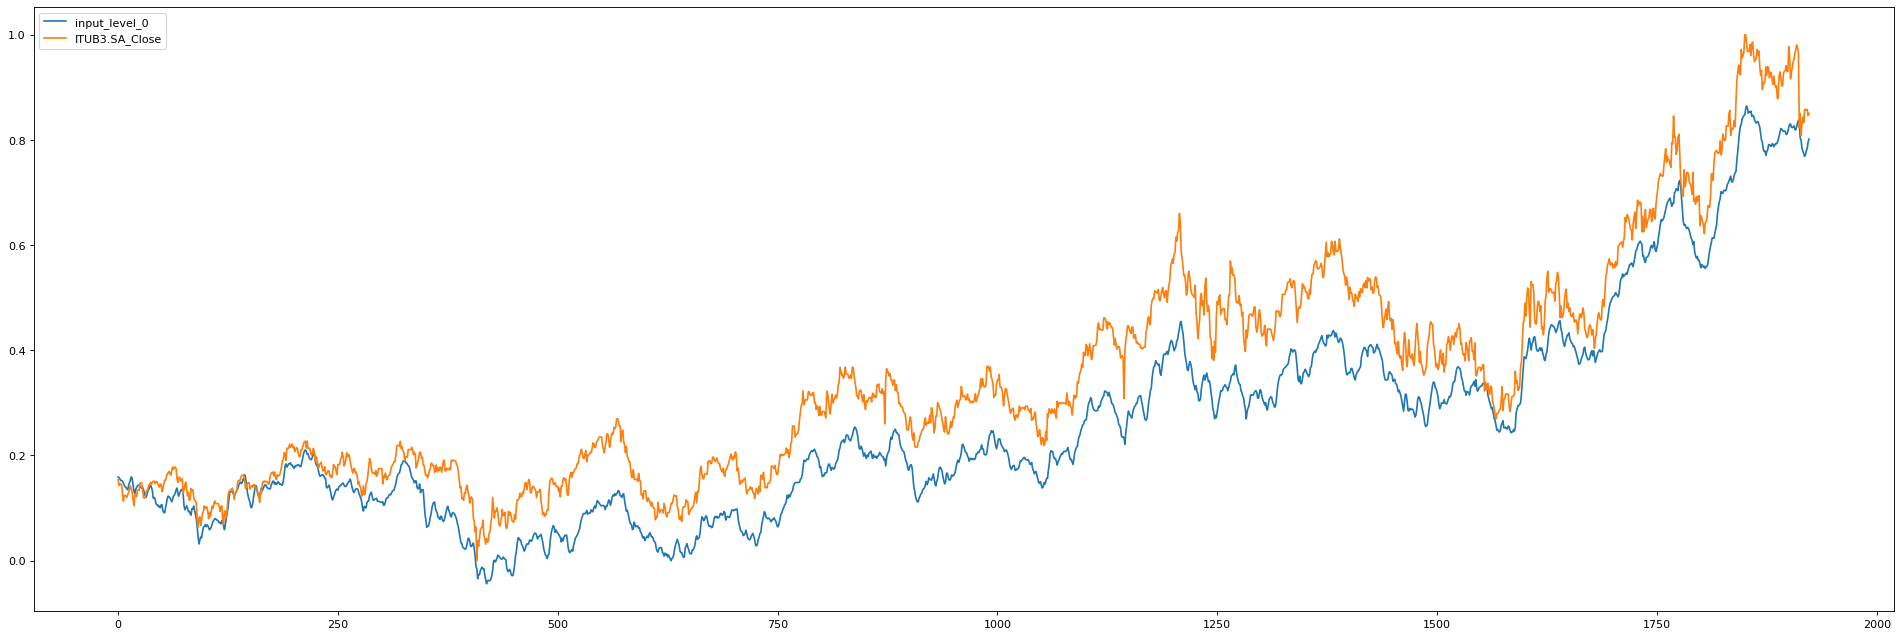

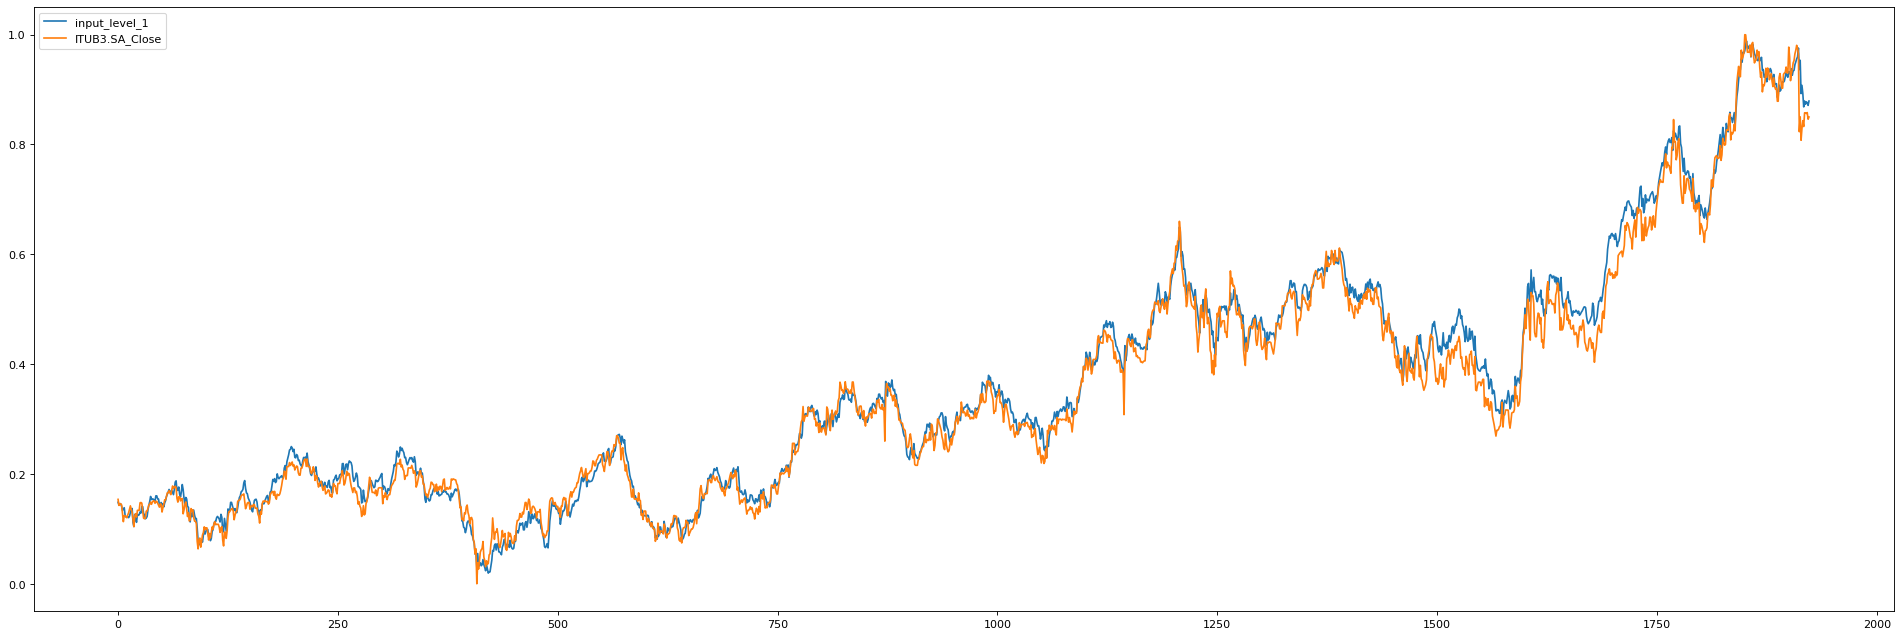

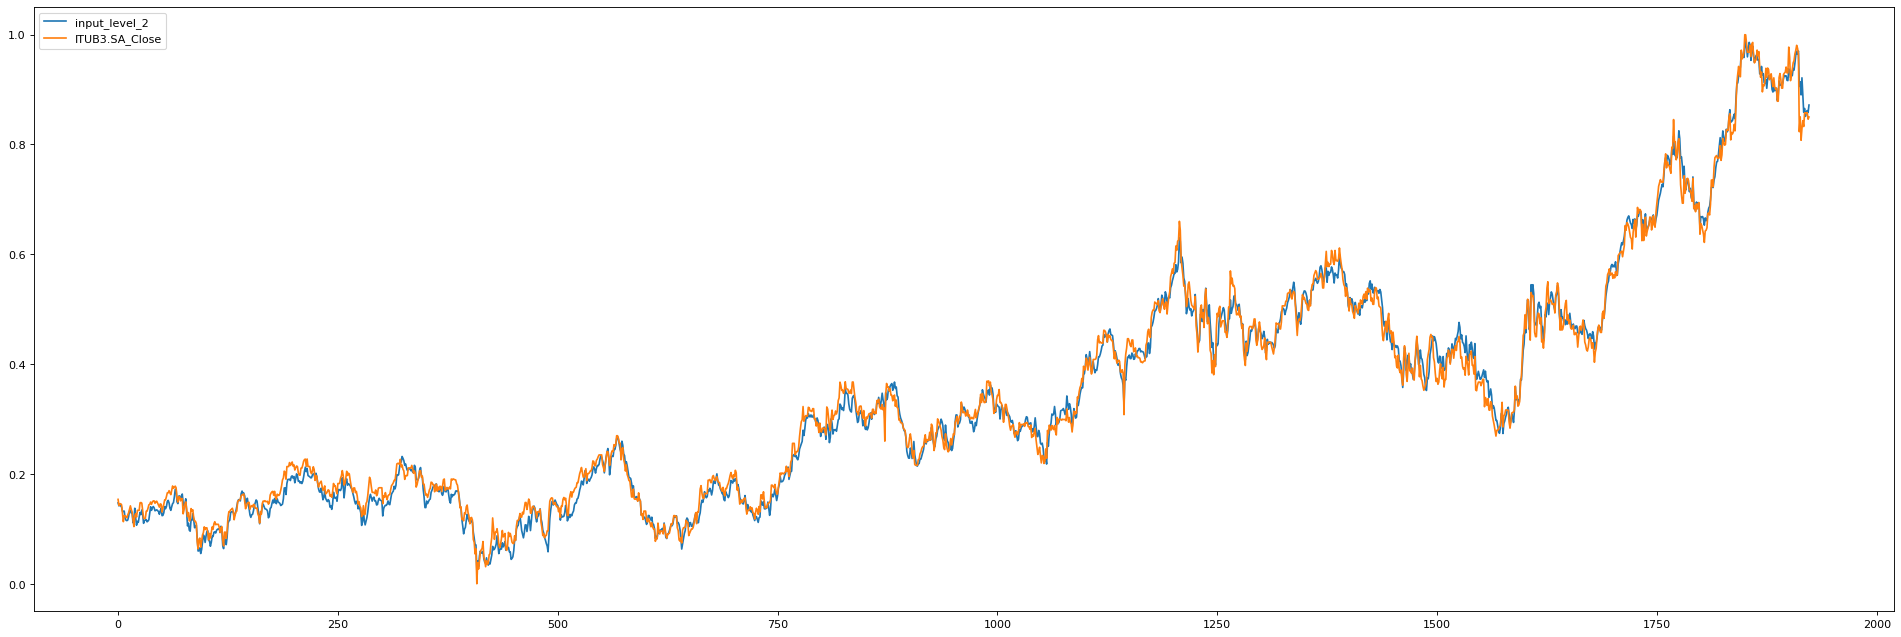

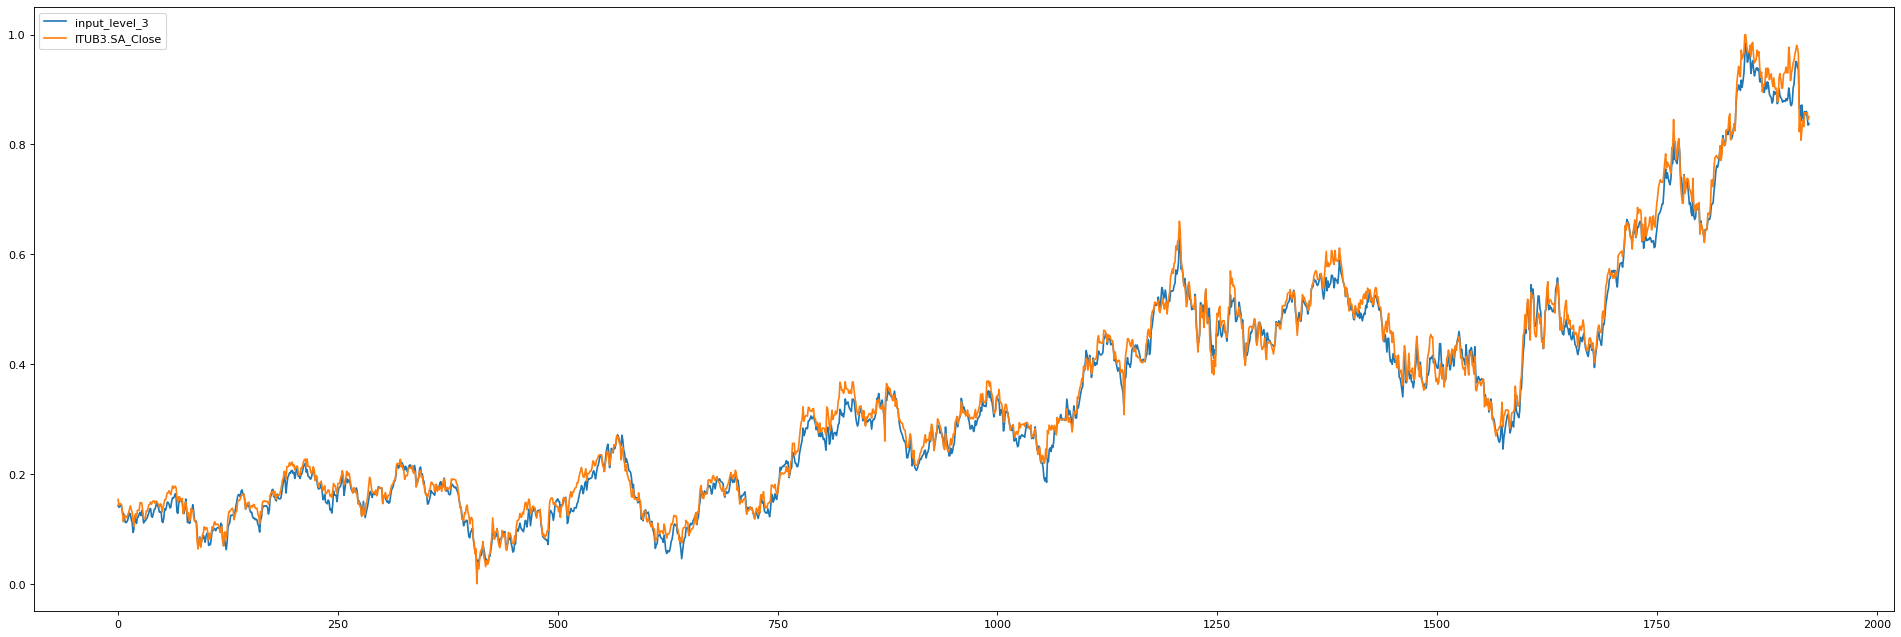

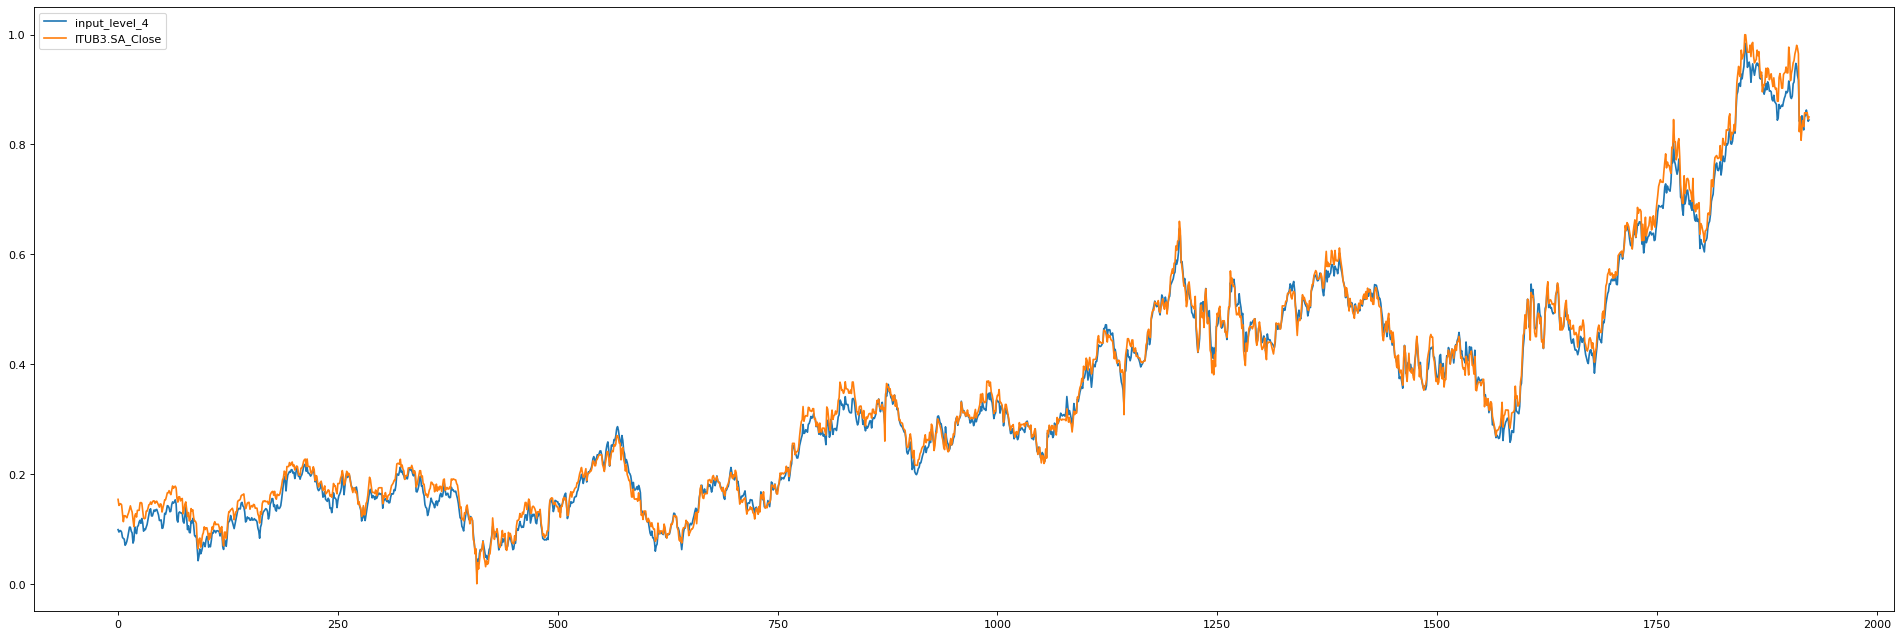

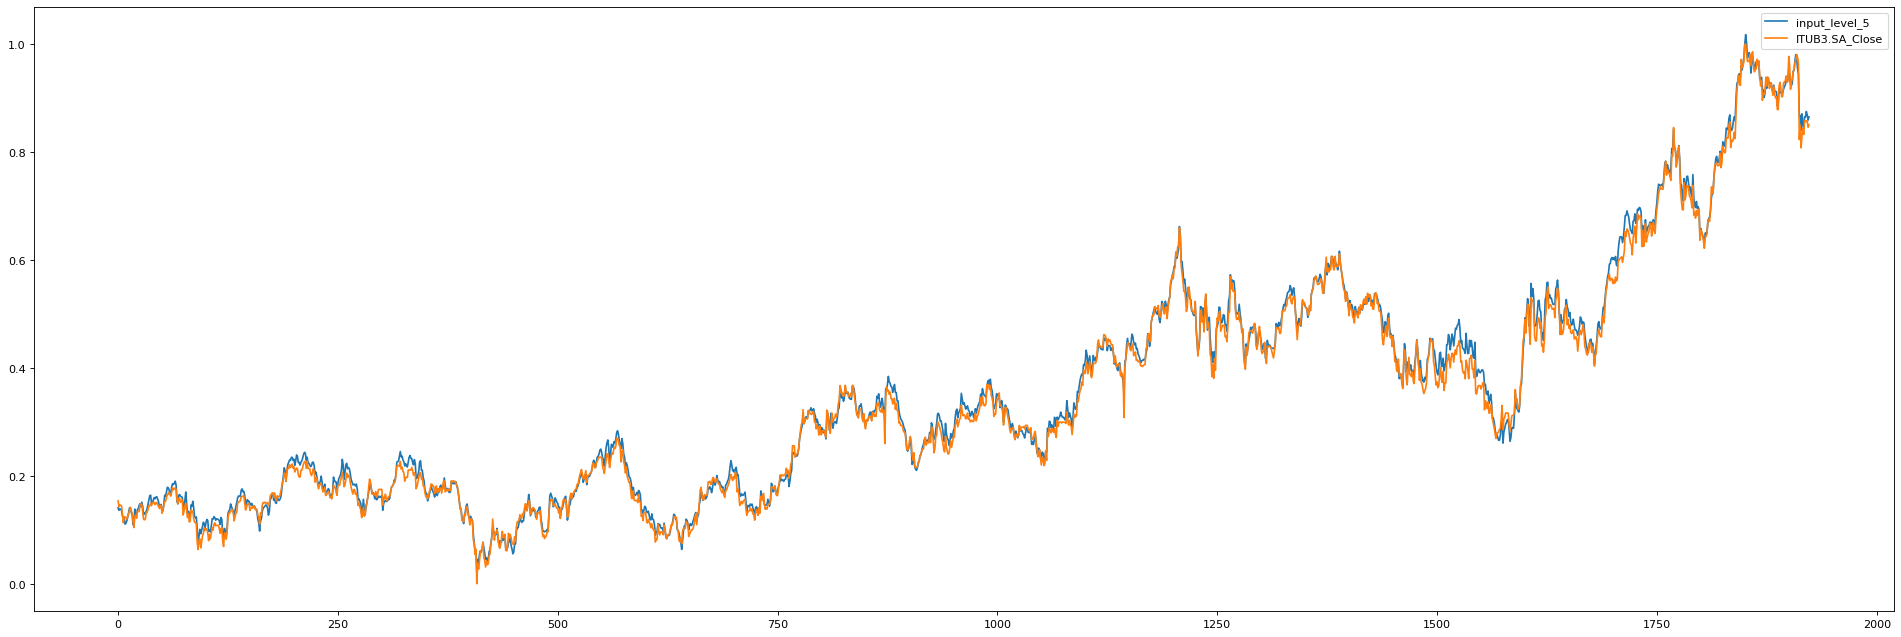

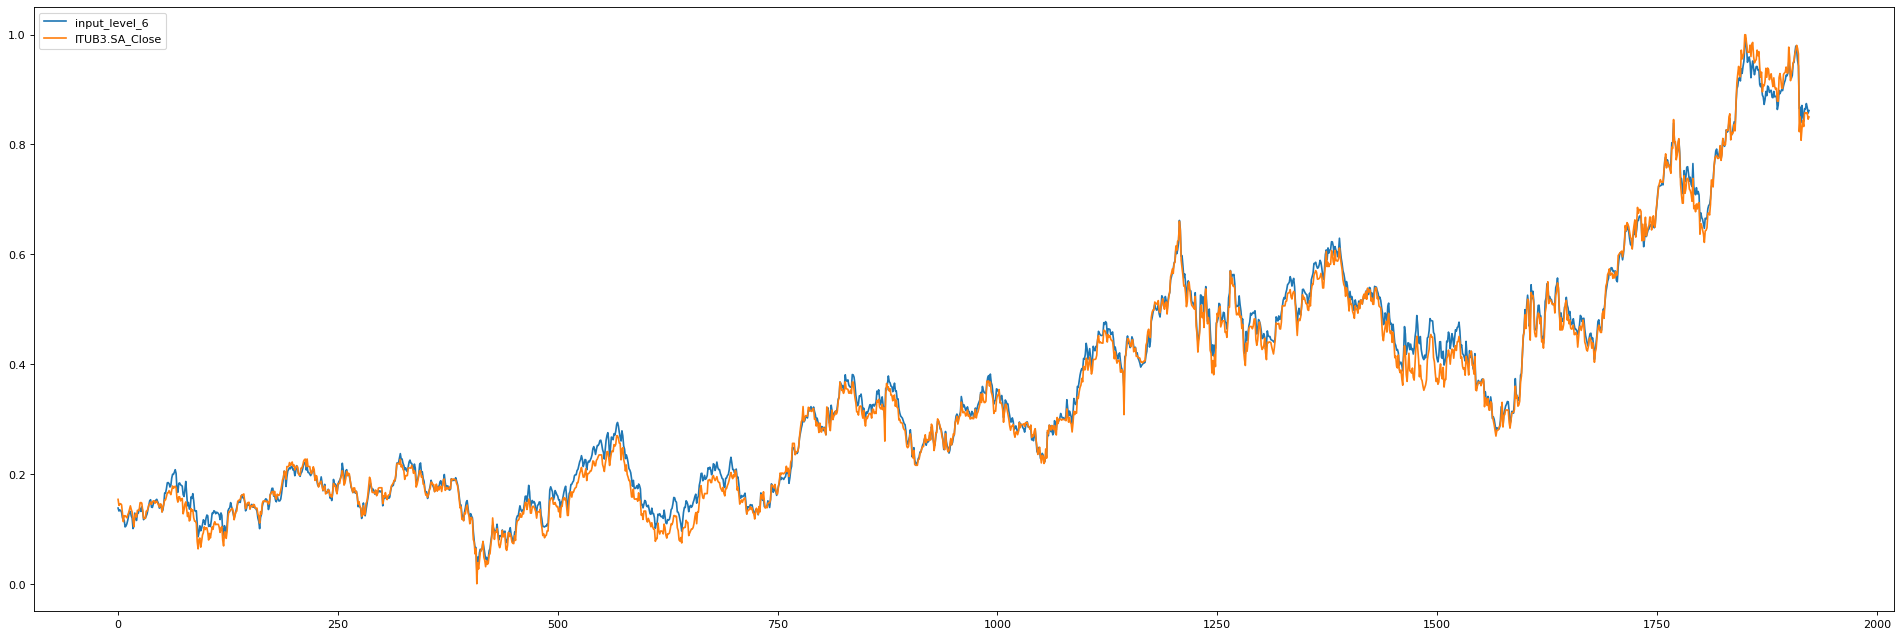

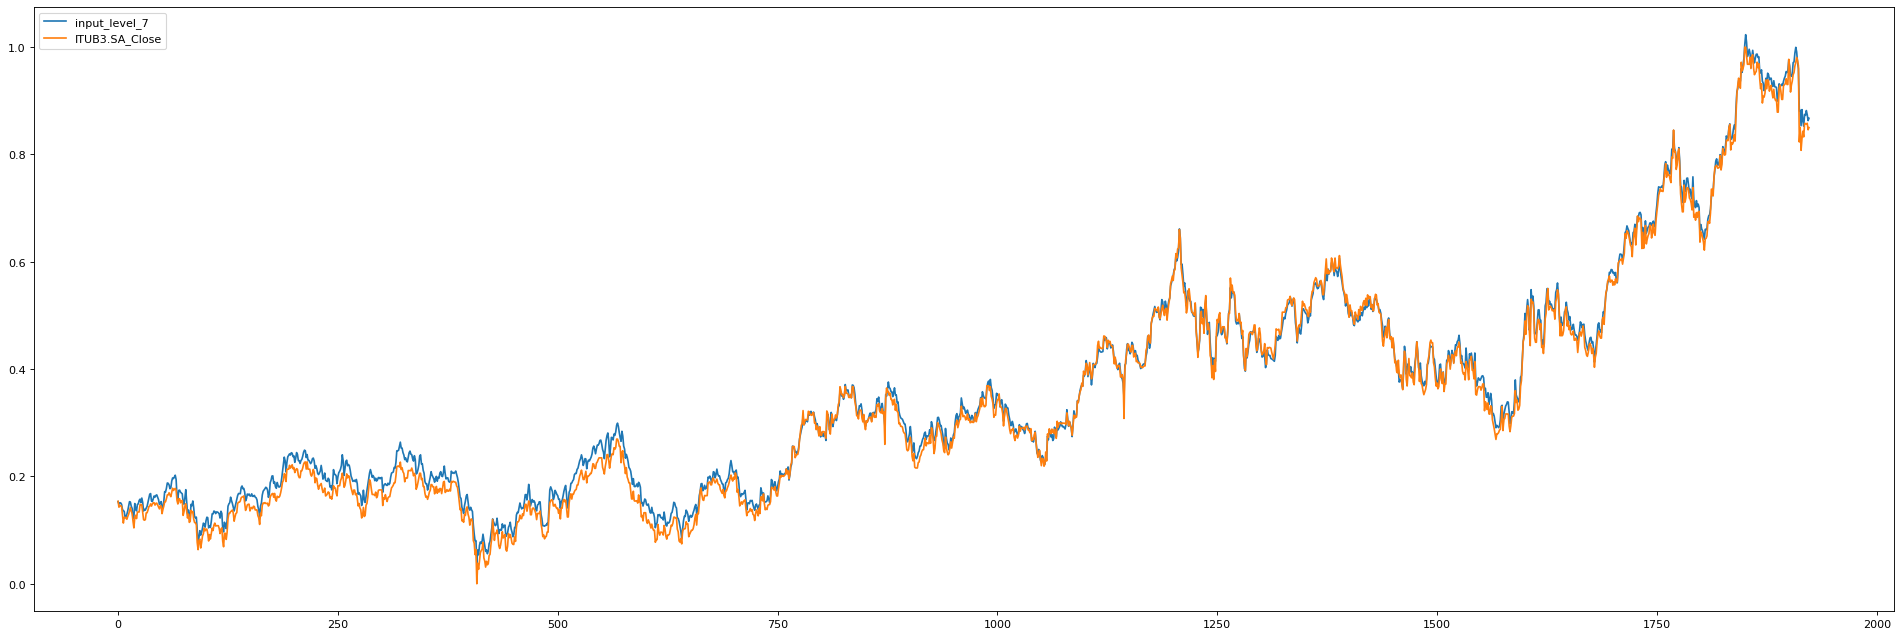

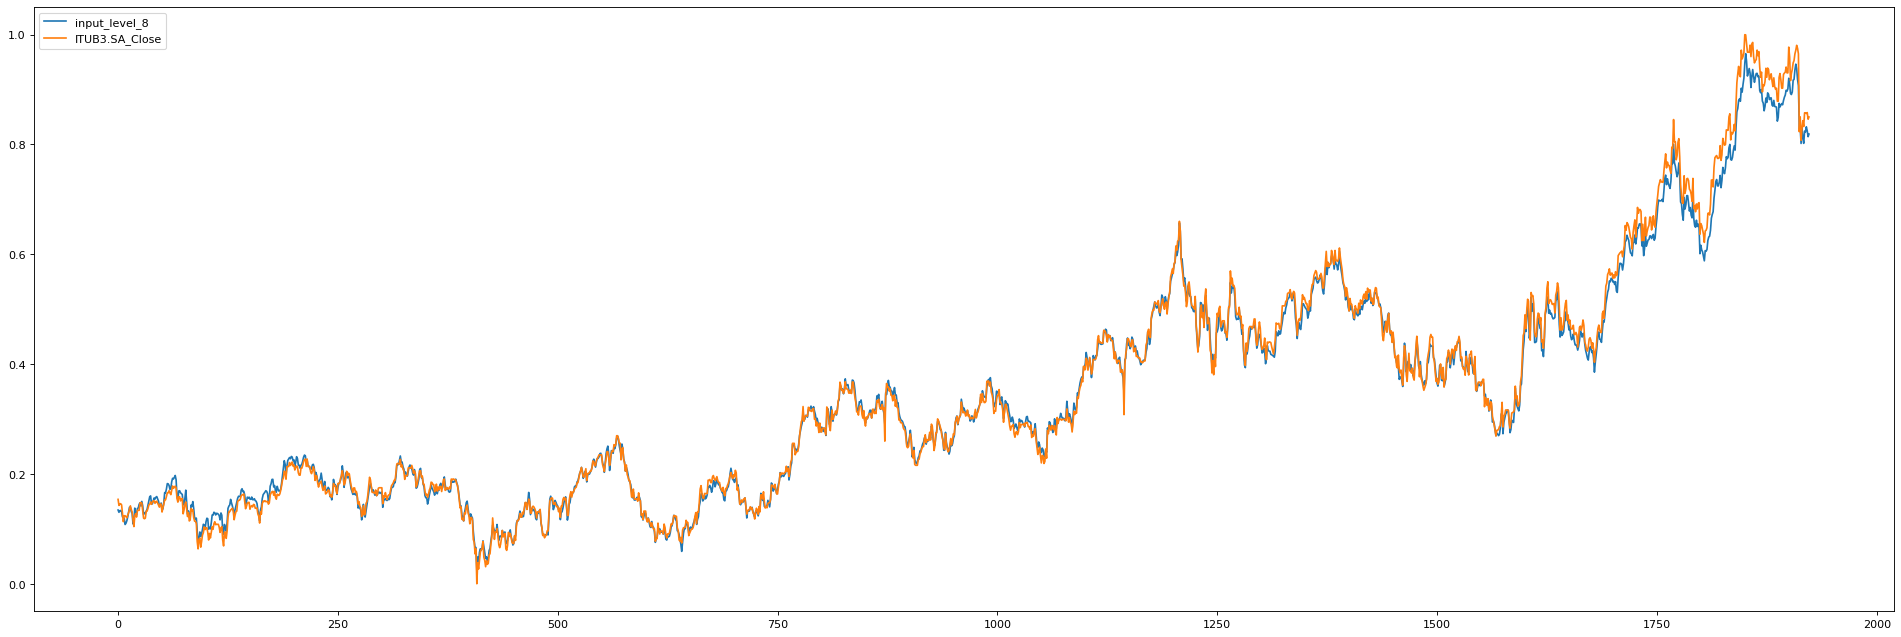

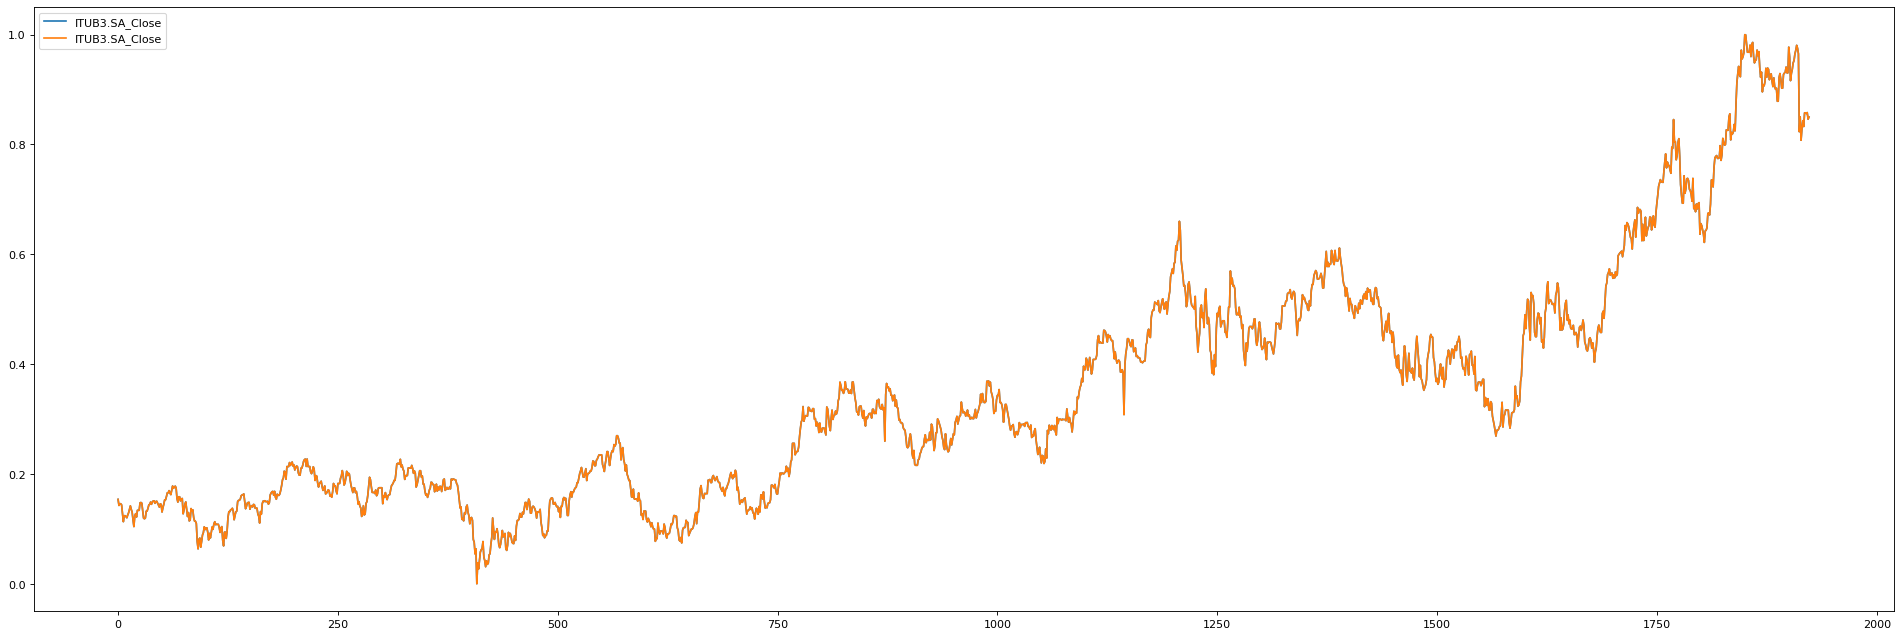

[1.6067933327352772, 0.0722803541301296, 0.06182152883072826, 0.059732336236573806, 0.06363058225257229, 0.041555812496979545, 0.05012704811828367, 0.06536647409650015, 0.03525382117236947, 0.0]
0.2056561290069414


In [9]:
from sklearn.metrics import mean_absolute_percentage_error as mape

mape_list = list()

for i in chm._list_stages_bottom_up[0]._regressor.ds.columns:

    plt.figure(figsize=(30, 10), dpi=80)
    mape_list.append(mape(chm._list_stages_bottom_up[0]._regressor.ds[i],chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close']))
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds[i], label=i)
    plt.plot(chm._list_stages_bottom_up[0]._regressor.ds['ITUB3.SA_Close'], label='ITUB3.SA_Close')
    plt.legend()
    plt.show()

print(mape_list)
print(sum(mape_list)/len(mape_list))